# MDN Hands On Tutorial
This notebook demonstrates the construction of a simple MDN, and compares it to a regular neural network.

Read about MDNs on the [original paper](https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) by C. Bishop.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

The network we'll construct will try to learn the following relation between $x$ and $f(x)$: 

$$f(x) = x^2-6x+9$$


Note that this simply $y = x^2$ shifted three steps to the left (global minimum is at $x=3$).

In [2]:
def f(x):
    return x**2-6*x+9 

In order to make the data a little bit more relaistic, we'll add a normally-distributed noise, which will be location-dependent - the larger $x$ is, the larger the noisier the data will be. So, uur data generator will obey the following relation:

$$g(x) = N(f(x),\sigma_0 x)$$

Where $N(\mu,\sigma)$ is the normal distribution with mean $\mu$ and STD of $\sigma$.

The `data_generator` below function creates $n$ nosiy data samples for a given `x`, where $n$ is defined by `samples` 

In [3]:
def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

We'll now generate out dataset for $1<x<5$.

The purple line in the plot presents the "clean" function $f(x)$ for this range.

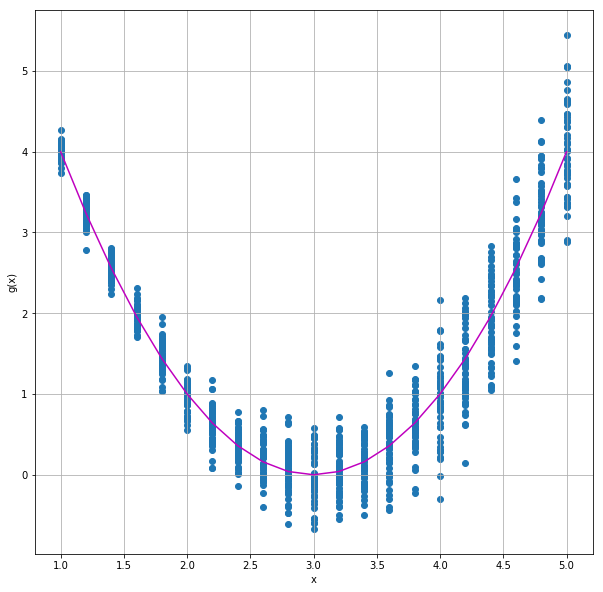

In [4]:
sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1,5.1,0.2)

plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
plt.scatter(x_arr,y_arr)
plt.plot(x_vals,map(f,x_vals),c='m')

## Regular neural network
We'll now train a neural network which will receive $x$ as input and our noisy $g(x)$ but will have to learn the relation $x \rightarrow f(x)$.

The network is constructed of two hidden layers, each with 12 nodes and the $\tanh(x)$ activation function (note we don't use any activation on the last output layer).

We set the learning rate $\alpha=0.0003$, 50 examples per mini-batch and a total of 1000 epoches.

Epoch 0 | cost = 3.7036
Epoch 50 | cost = 1.4659
Epoch 100 | cost = 0.3123
Epoch 150 | cost = 0.2031
Epoch 200 | cost = 0.1579
Epoch 250 | cost = 0.1394
Epoch 300 | cost = 0.1301
Epoch 350 | cost = 0.1242
Epoch 400 | cost = 0.1207
Epoch 450 | cost = 0.1186
Epoch 500 | cost = 0.1176
Epoch 550 | cost = 0.1169
Epoch 600 | cost = 0.1165
Epoch 650 | cost = 0.1162
Epoch 700 | cost = 0.1160
Epoch 750 | cost = 0.1158
Epoch 800 | cost = 0.1157
Epoch 850 | cost = 0.1155
Epoch 900 | cost = 0.1154
Epoch 950 | cost = 0.1153
Final cost: 0.1152


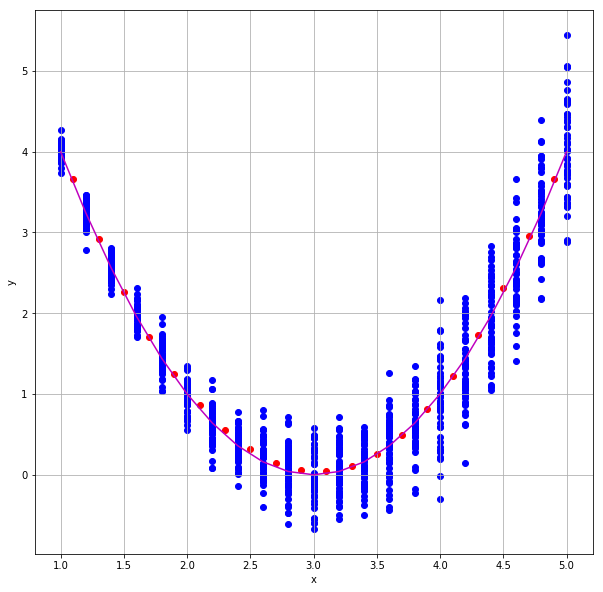

In [5]:
hidden_layers_size = [12,12,12]
epochs = 1000
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

tf.reset_default_graph()
x = tf.placeholder(name='x',shape=(None,1),dtype=tf.float32)
y = tf.placeholder(name='y',shape=(None,1),dtype=tf.float32)

layer = x
for l in hidden_layers_size:
    layer = tf.layers.dense(inputs=layer, units=l, activation=tf.nn.tanh,
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
output = tf.layers.dense(inputs=layer, units=1, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer())

cost = tf.reduce_mean(tf.losses.mean_squared_error(labels=y,predictions=output))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(batch_num):
            x_batch = np.expand_dims(x_batches[i],axis=1)
            y_batch = np.expand_dims(y_batches[i],axis=1)
            _, c = sess.run([optimizer,cost], feed_dict={x:x_batch, y:y_batch})
            avg_cost += c/batch_num
        if epoch % display_step == 0:
            print('Epoch {0} | cost = {1:.4f}'.format(epoch,avg_cost))
    y_pred = sess.run(output,feed_dict={x:np.expand_dims(x_test,axis=1)})
    print('Final cost: {0:.4f}'.format(avg_cost))

plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_arr,y_arr,c='b')
plt.scatter(x_test,y_pred,c='r')
plt.plot(x_vals,map(f,x_vals),c='m')
plt.show()

It seems to be doing quite good in predicting $f(x)$, but we can clearly see that the network learnt nothing about the size of the noise. 

## Mixture density network (MDN)
Let's try an MDN now. We'll use the same network as in the previous section, with one important change:
the output layer now has two nodes (which are constructed as two layers of 1 node for technical simplicity), which we named `mu` and `sigma`

Note the new cost function: we create a normal distribution out of the predicted `mu` and `sigma`, and then minimize the negative log-likelihood of this distribution yielding the traget value `y`. Mathematically, our cost function is the negative logarithm of the normal distribution's probability density function (PDF):

$$J(\mu,\sigma) = -\log\left(\frac{1}{\sqrt{2\pi\sigma}}\exp^{-\frac{(y-\mu)^{2}}{2\sigma^{2}}}\right)$$

In [6]:
def mdn_cost(mu, sigma, y):
    dist = tf.distributions.Normal(loc=mu, scale=tf.abs(sigma))
    return tf.reduce_mean(-dist.log_prob(y))

Epoch 0 | cost = 16.9467
Epoch 50 | cost = 1.8365
Epoch 100 | cost = 1.7872
Epoch 150 | cost = 1.7477
Epoch 200 | cost = 1.6972
Epoch 250 | cost = 1.5931
Epoch 300 | cost = 0.8487
Epoch 350 | cost = 0.5141
Epoch 400 | cost = 0.3883
Epoch 450 | cost = 0.3046
Epoch 500 | cost = 0.2515
Epoch 550 | cost = 0.2152
Epoch 600 | cost = 0.1907
Epoch 650 | cost = 0.1747
Epoch 700 | cost = 0.1645
Epoch 750 | cost = 0.1580
Epoch 800 | cost = 0.1537
Epoch 850 | cost = 0.1507
Epoch 900 | cost = 0.1485
Epoch 950 | cost = 0.1468
Final cost: 0.1455


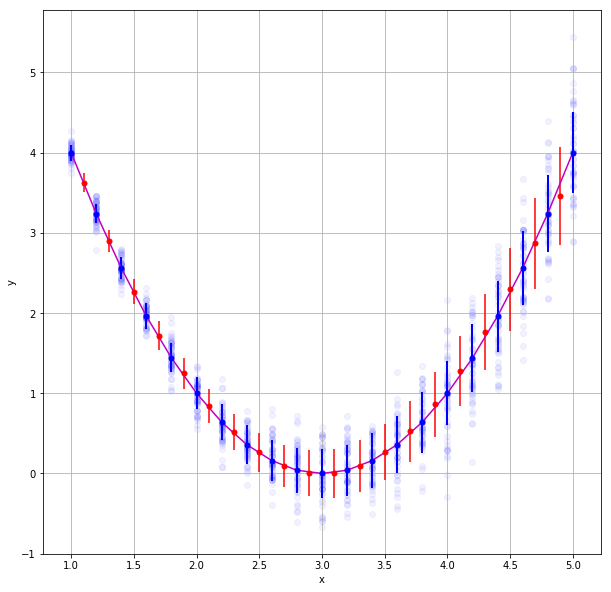

In [7]:
hidden_layers_size = [12,12,12]
epochs = 1000
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

tf.reset_default_graph()
x = tf.placeholder(name='x',shape=(None,1),dtype=tf.float32)
y = tf.placeholder(name='y',shape=(None,1),dtype=tf.float32)

layer = x
for l in hidden_layers_size:
    layer = tf.layers.dense(inputs=layer, units=l, activation=tf.nn.tanh,
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
mu = tf.layers.dense(inputs=layer, units=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
sigma = tf.layers.dense(inputs=layer, units=1, kernel_initializer=tf.contrib.layers.xavier_initializer())

cost = mdn_cost(mu, sigma, y)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        avg_cost = 0.0
        for i in range(batch_num):
            x_batch = np.expand_dims(x_batches[i],axis=1)
            y_batch = np.expand_dims(y_batches[i],axis=1)
            _, c = sess.run([optimizer,cost], feed_dict={x:x_batch, y:y_batch})
            avg_cost += c/batch_num
        if epoch % display_step == 0:
            print('Epoch {0} | cost = {1:.4f}'.format(epoch,avg_cost))
            #print(sess.run([mu,sigma,y,tf.distributions.Normal(loc=mu, scale=sigma).prob(y)],feed_dict={x:x_batch, y:y_batch}))
    mu_pred, sigma_pred = sess.run([mu,sigma],feed_dict={x:np.expand_dims(x_test,axis=1)})
    print('Final cost: {0:.4f}'.format(avg_cost))

plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10)
plt.scatter(x_arr,y_arr,c='b',alpha=0.05)
plt.errorbar(x_vals,map(f,x_vals),yerr=map(lambda x: sigma_0*x,x_vals),c='b',lw=2,ls='None',marker='.',ms=10)
plt.plot(x_vals,map(f,x_vals),c='m')
plt.show()

The plot above shows the results learnt by the network. In red are the networks predictions for $\mu$ and $\sigma$, and in blue are the actual $\mu$ and $\sigma$ used for the training set. The actual data can be seen faded in the background. We can clearly see the network has learnt not just $x \rightarrow f(x)$, but also the noise creating $x \rightarrow g(x)$.